# Analyzer Package Dependency Analysis

This notebook analyzes the distribution of analyzer versions in packages that depend on the Dart analyzer library. The analysis focuses on:

1. **Version categorization**: Grouping packages by analyzer version ranges (< 7.0, 7.0-7.3, ≥ 7.4)
2. **Package freshness**: Distinguishing between recently updated packages (last 12 months) vs. older packages
3. **Direct vs. indirect dependencies**: Identifying packages with explicit analyzer versions vs. those without

The data source is the CSV export from the package dependency analysis tool, containing metadata about packages that depend on the analyzer library.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime, timedelta
from typing import Optional, Dict, Tuple
import warnings

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Matplotlib is building the font cache; this may take a moment.


Libraries imported successfully!


## 1. CSV Data Loading and Preparation

Loading the package export data and preparing the relevant columns for analysis.

In [2]:
# Load the CSV data
csv_file_path = 'results/packages_export_2025-07-03T23-39-18.csv'

try:
    # Read CSV with proper handling of potential encoding issues
    df = pd.read_csv(csv_file_path, encoding='utf-8')
    print(f"Successfully loaded {len(df)} package records")
    
    # Display basic information about the dataset
    print(f"\nDataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    # Show first few rows
    print("\nFirst 5 rows:")
    display(df.head())
    
    # Check for missing values in key columns
    print("\nMissing values in key columns:")
    key_columns = ['Package Name', 'Analyzer Version', 'Published Date', 'Updated At']
    for col in key_columns:
        if col in df.columns:
            missing_count = df[col].isna().sum()
            print(f"  {col}: {missing_count} ({missing_count/len(df)*100:.1f}%)")
            
except Exception as e:
    print(f"Error loading CSV file: {e}")
    print("Please ensure the file path is correct and the file is accessible.")

Successfully loaded 1259 package records

Dataset shape: (1259, 9)
Columns: ['Package Name', 'Analyzer Version', 'Dev Version', 'Dev Date', 'Published Date', 'Published Version', 'Repository URL', 'Created At', 'Updated At']

First 5 rows:


,Package Name,Analyzer Version,Dev Version,Dev Date,Published Date,Published Version,Repository URL,Created At,Updated At
0,meta_types_generator,NaN,NaN,2025-07-03T23:38:35.000,2018-08-07T06:29:14.000,0.1.0,NaN,2025-07-03T23:38:35.000,2025-07-03T23:38:35.000
1,tenon_flutter,NaN,NaN,2025-07-03T23:38:35.000,2025-04-08T09:20:39.000,2.0.0,NaN,2025-07-03T23:38:35.000,2025-07-03T23:38:35.000
2,codemetrics,NaN,NaN,2025-07-03T23:38:35.000,2018-07-06T17:32:57.000,1.0.0-alpha+1,NaN,2025-07-03T23:38:35.000,2025-07-03T23:38:35.000
3,meta_types_json_generator,NaN,NaN,2025-07-03T23:38:34.000,2018-08-07T06:38:18.000,0.0.1,NaN,2025-07-03T23:38:34.000,2025-07-03T23:38:34.000
4,retrofit_generator_d,NaN,NaN,2025-07-03T23:38:33.000,2021-02-26T02:04:49.000,1.4.1+2,https://github.com/trevorwang/retrofit.dart/,2025-07-03T23:38:33.000,2025-07-03T23:38:33.000



Missing values in key columns:
  Package Name: 0 (0.0%)
  Analyzer Version: 706 (56.1%)
  Published Date: 0 (0.0%)
  Updated At: 0 (0.0%)


In [3]:
# Data preparation and cleaning
def prepare_data(df):
    """Prepare the dataset for analysis by converting date columns and handling missing values."""
    df_clean = df.copy()
    
    # Convert date columns to datetime
    date_columns = ['Published Date', 'Updated At', 'Created At', 'Dev Date']
    for col in date_columns:
        if col in df_clean.columns:
            df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
    
    # Fill missing Analyzer Version with 'No Direct Version'
    df_clean['Analyzer Version'] = df_clean['Analyzer Version'].fillna('No Direct Version')
    
    # Create a cleaner version indicator
    df_clean['Has_Direct_Version'] = df_clean['Analyzer Version'] != 'No Direct Version'
    
    return df_clean

# Apply data preparation
if 'df' in locals():
    df_prepared = prepare_data(df)
    
    print("Data preparation completed!")
    print(f"\nPackages with direct analyzer version: {df_prepared['Has_Direct_Version'].sum()}")
    print(f"Packages without direct analyzer version: {(~df_prepared['Has_Direct_Version']).sum()}")
    
    # Show some examples of analyzer versions
    print(f"\nSample analyzer versions (non-empty):")
    sample_versions = df_prepared[df_prepared['Has_Direct_Version']]['Analyzer Version'].dropna().head(10)
    for version in sample_versions:
        print(f"  - {version}")
else:
    print("Please load the data first by running the previous cell.")

Data preparation completed!

Packages with direct analyzer version: 553
Packages without direct analyzer version: 706

Sample analyzer versions (non-empty):
  - ^0.39.4
  - ^1.1.0
  - ^0.39.8
  - >=0.36.0 <0.39.0
  - ^0.39.17
  - any
  - ^0.39.0
  - >=0.39.0 <0.40.0
  - >=0.22.0 <0.23.0
  - ^0.38.1


## 2. Analyzer Version Extraction and Categorization

Extracting the main version numbers from analyzer version constraints and categorizing them into version buckets.

In [4]:
def extract_version_number(version_constraint: str) -> Optional[Tuple[int, int]]:
    """
    Extract the main version number (major.minor) from version constraints.
    
    Examples:
    - "^6.5.0" -> (6, 5)
    - ">=7.0.0 <8.0.0" -> (7, 0)
    - "^7.4.5" -> (7, 4)
    - "any" -> None
    """
    if not version_constraint or version_constraint == 'No Direct Version':
        return None
    
    # Handle "any" constraint
    if version_constraint.lower() == 'any':
        return None
    
    # Extract version patterns using regex
    # Patterns: ^x.y.z, >=x.y.z, x.y.z, etc.
    patterns = [
        r'\^?(\d+)\.(\d+)\.?\d*',  # ^6.5.0, 6.5.0, 6.5
        r'>=\s*(\d+)\.(\d+)\.?\d*',  # >=7.0.0
        r'(\d+)\.(\d+)\.?\d*',  # Simple version numbers
    ]
    
    for pattern in patterns:
        match = re.search(pattern, version_constraint)
        if match:
            major = int(match.group(1))
            minor = int(match.group(2))
            return (major, minor)
    
    return None

def categorize_version(version_tuple: Optional[Tuple[int, int]]) -> str:
    """
    Categorize version into buckets based on major.minor version.
    
    Categories:
    - "< 7.0": Versions below 7.0
    - "7.0-7.3": Versions 7.0 to 7.3 (inclusive)
    - "≥ 7.4": Versions 7.4 and above
    - "No Direct Version": No version constraint found
    """
    if version_tuple is None:
        return "No Direct Version"
    
    major, minor = version_tuple
    
    if major < 7:
        return "< 7.0"
    elif major == 7:
        if minor <= 3:
            return "7.0-7.3"
        else:
            return "≥ 7.4"
    else:  # major > 7
        return "≥ 7.4"

# Test the functions with sample data
if 'df_prepared' in locals():
    print("Testing version extraction with sample data:")
    
    sample_versions = [
        "^6.5.0", ">=7.0.0 <8.0.0", "^7.4.5", "any", "^0.39.4", 
        "7.2.0", "null", ">=0.39.0 <0.40.0", "^7.3.0"
    ]
    
    for version_str in sample_versions:
        version_tuple = extract_version_number(version_str)
        category = categorize_version(version_tuple)
        print(f"  '{version_str}' -> {version_tuple} -> '{category}'")
        
else:
    print("Please prepare the data first by running the previous cells.")

Testing version extraction with sample data:
  '^6.5.0' -> (6, 5) -> '< 7.0'
  '>=7.0.0 <8.0.0' -> (7, 0) -> '7.0-7.3'
  '^7.4.5' -> (7, 4) -> '≥ 7.4'
  'any' -> None -> 'No Direct Version'
  '^0.39.4' -> (0, 39) -> '< 7.0'
  '7.2.0' -> (7, 2) -> '7.0-7.3'
  'null' -> None -> 'No Direct Version'
  '>=0.39.0 <0.40.0' -> (0, 39) -> '< 7.0'
  '^7.3.0' -> (7, 3) -> '7.0-7.3'


In [5]:
# Apply version categorization to the dataset
if 'df_prepared' in locals():
    # Extract version information
    df_prepared['Version_Tuple'] = df_prepared['Analyzer Version'].apply(extract_version_number)
    df_prepared['Version_Category'] = df_prepared['Version_Tuple'].apply(categorize_version)
    
    # Display distribution of version categories
    version_distribution = df_prepared['Version_Category'].value_counts()
    print("Distribution of analyzer version categories:")
    print(version_distribution)
    print(f"\nPercentage distribution:")
    percentage_dist = (version_distribution / len(df_prepared) * 100).round(1)
    for category, count in version_distribution.items():
        pct = percentage_dist[category]
        print(f"  {category}: {count} packages ({pct}%)")
    
    # Show some examples for each category
    print(f"\nExample packages by category:")
    for category in version_distribution.index:
        examples = df_prepared[df_prepared['Version_Category'] == category]
        if len(examples) > 0:
            print(f"\n{category}:")
            sample_size = min(3, len(examples))
            for _, row in examples.head(sample_size).iterrows():
                version_info = row['Analyzer Version'] if row['Analyzer Version'] != 'No Direct Version' else 'N/A'
                print(f"  - {row['Package Name']}: {version_info}")
                
else:
    print("Please prepare the data first by running the previous cells.")

Distribution of analyzer version categories:
Version_Category
No Direct Version    717
< 7.0                405
7.0-7.3               95
≥ 7.4                 42
Name: count, dtype: int64

Percentage distribution:
  No Direct Version: 717 packages (56.9%)
  < 7.0: 405 packages (32.2%)
  7.0-7.3: 95 packages (7.5%)
  ≥ 7.4: 42 packages (3.3%)

Example packages by category:

No Direct Version:
  - meta_types_generator: N/A
  - tenon_flutter: N/A
  - codemetrics: N/A

< 7.0:
  - hash_compare: ^0.39.4
  - emmet: ^1.1.0
  - dart_to_js_transpiler: ^0.39.8

7.0-7.3:
  - best_theme_generator: ^7.0.0
  - test_filename_lint: ^7.3.0
  - json_model_mapper_gen: ^7.3.0

≥ 7.4:
  - pinto: ^7.4.5
  - celest_cli: ^7.4.0
  - analysis_server_plugin: ^8.0.0-0


## 3. Package Age Grouping (Update Recency)

Categorizing packages based on when they were last updated to distinguish between actively maintained and potentially outdated packages.

In [6]:
# Calculate package age based on last update
def categorize_by_age(updated_date: pd.Timestamp, reference_date: datetime = datetime(2025, 7, 3)) -> str:
    """
    Categorize packages by how recently they were updated.
    
    Categories:
    - "Recently Updated": Updated within the last 12 months
    - "Older Package": Updated more than 12 months ago
    """
    if pd.isna(updated_date):
        return "Unknown Update Date"
    
    # Calculate the cutoff date (12 months ago from reference date)
    cutoff_date = reference_date - timedelta(days=365)
    
    if updated_date >= cutoff_date:
        return "Recently Updated"
    else:
        return "Older Package"

# Apply age categorization
if 'df_prepared' in locals():
    # Use the data collection date as reference (July 3, 2025)
    reference_date = datetime(2025, 7, 3)
    cutoff_date = reference_date - timedelta(days=365)
    
    print(f"Reference date: {reference_date.strftime('%Y-%m-%d')}")
    print(f"Cutoff date for 'recent' updates: {cutoff_date.strftime('%Y-%m-%d')}")
    
    # Categorize packages by age
    df_prepared['Age_Category'] = df_prepared['Updated At'].apply(
        lambda x: categorize_by_age(x, reference_date)
    )
    
    # Display age distribution
    age_distribution = df_prepared['Age_Category'].value_counts()
    print(f"\nPackage age distribution:")
    for category, count in age_distribution.items():
        percentage = count / len(df_prepared) * 100
        print(f"  {category}: {count} packages ({percentage:.1f}%)")
    
    # Show date ranges for each category
    print(f"\nDate ranges by category:")
    for category in age_distribution.index:
        if category != "Unknown Update Date":
            subset = df_prepared[df_prepared['Age_Category'] == category]['Updated At'].dropna()
            if len(subset) > 0:
                min_date = subset.min().strftime('%Y-%m-%d')
                max_date = subset.max().strftime('%Y-%m-%d')
                print(f"  {category}: {min_date} to {max_date}")
                
else:
    print("Please prepare the data first by running the previous cells.")

Reference date: 2025-07-03
Cutoff date for 'recent' updates: 2024-07-03

Package age distribution:
  Recently Updated: 1259 packages (100.0%)

Date ranges by category:
  Recently Updated: 2025-07-03 to 2025-07-03


## 4. Visualization: Analyzer Version Distribution by Package Age

Creating grouped visualizations to show the relationship between analyzer versions and package update recency.

Cross-tabulation of Version Categories vs Age Categories:
Age_Category       Recently Updated
Version_Category                   
7.0-7.3                          95
< 7.0                           405
No Direct Version               717
≥ 7.4                            42

Percentage distribution within each age category:
Age_Category       Recently Updated
Version_Category                   
7.0-7.3                         7.5
< 7.0                          32.2
No Direct Version              56.9
≥ 7.4                           3.3


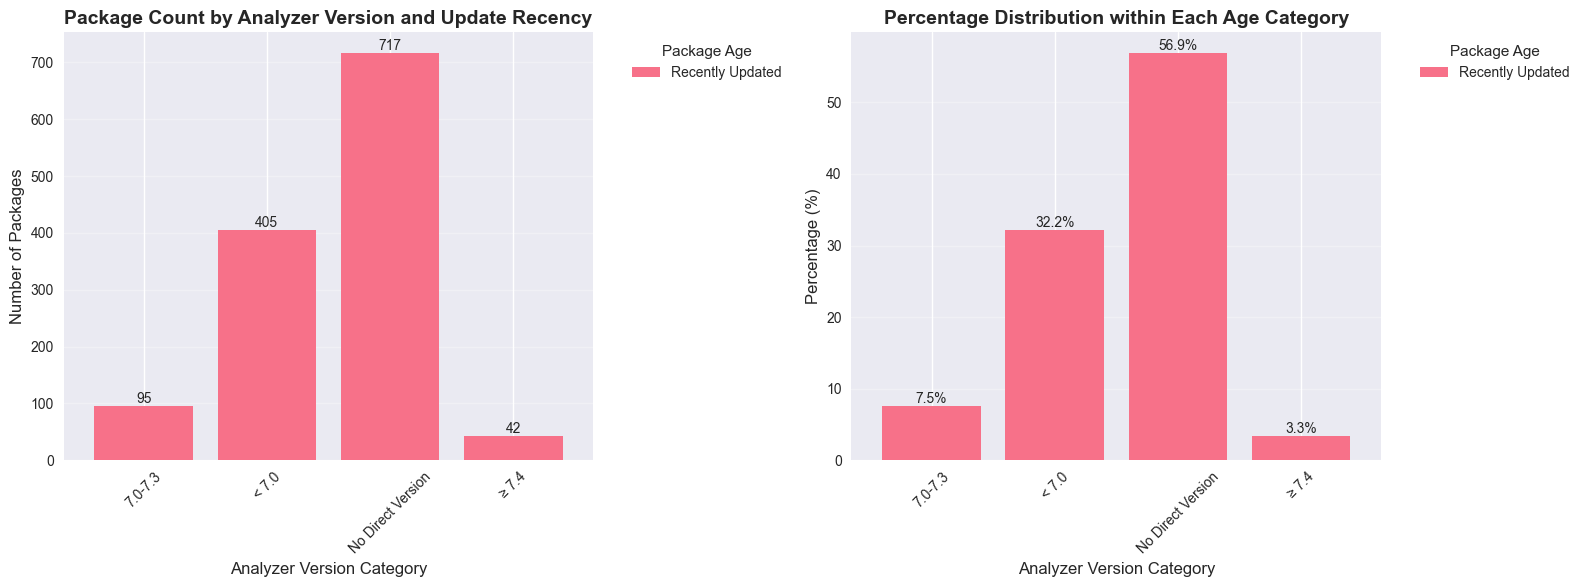


📊 Key Insights:
• Total packages analyzed: 1259
• Recently updated packages (last 12 months): 1259 (100.0%)
• Older packages (>12 months): 0 (0.0%)
• Recently Updated: 717/1259 packages have no direct analyzer version (56.9%)


In [7]:
# Create cross-tabulation and grouped bar chart
if 'df_prepared' in locals():
    # Create crosstab for analysis
    crosstab = pd.crosstab(df_prepared['Version_Category'], df_prepared['Age_Category'])
    print("Cross-tabulation of Version Categories vs Age Categories:")
    print(crosstab)
    
    # Calculate percentages within each age category
    crosstab_pct = pd.crosstab(df_prepared['Version_Category'], df_prepared['Age_Category'], normalize='columns') * 100
    print(f"\nPercentage distribution within each age category:")
    print(crosstab_pct.round(1))
    
    # Create the grouped bar chart
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Absolute counts
    crosstab.plot(kind='bar', ax=ax1, width=0.8)
    ax1.set_title('Package Count by Analyzer Version and Update Recency', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Analyzer Version Category', fontsize=12)
    ax1.set_ylabel('Number of Packages', fontsize=12)
    ax1.legend(title='Package Age', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for container in ax1.containers:
        ax1.bar_label(container, fmt='%d', fontsize=10)
    
    # Percentage within age categories
    crosstab_pct.plot(kind='bar', ax=ax2, width=0.8)
    ax2.set_title('Percentage Distribution within Each Age Category', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Analyzer Version Category', fontsize=12)
    ax2.set_ylabel('Percentage (%)', fontsize=12)
    ax2.legend(title='Package Age', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)
    
    # Add percentage labels on bars
    for container in ax2.containers:
        ax2.bar_label(container, fmt='%.1f%%', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Summary insights
    print(f"\n📊 Key Insights:")
    total_packages = len(df_prepared)
    recent_packages = len(df_prepared[df_prepared['Age_Category'] == 'Recently Updated'])
    older_packages = len(df_prepared[df_prepared['Age_Category'] == 'Older Package'])
    
    print(f"• Total packages analyzed: {total_packages}")
    print(f"• Recently updated packages (last 12 months): {recent_packages} ({recent_packages/total_packages*100:.1f}%)")
    print(f"• Older packages (>12 months): {older_packages} ({older_packages/total_packages*100:.1f}%)")
    
    # Version insights by age
    for age_cat in ['Recently Updated', 'Older Package']:
        if age_cat in crosstab.columns:
            subset = df_prepared[df_prepared['Age_Category'] == age_cat]
            no_version_count = len(subset[subset['Version_Category'] == 'No Direct Version'])
            print(f"• {age_cat}: {no_version_count}/{len(subset)} packages have no direct analyzer version ({no_version_count/len(subset)*100:.1f}%)")
            
else:
    print("Please prepare the data first by running the previous cells.")

## 5. Visualization: Direct vs. Indirect Analyzer Dependencies

Showing the proportion of packages with direct analyzer version constraints versus those with indirect dependencies or no repository information.

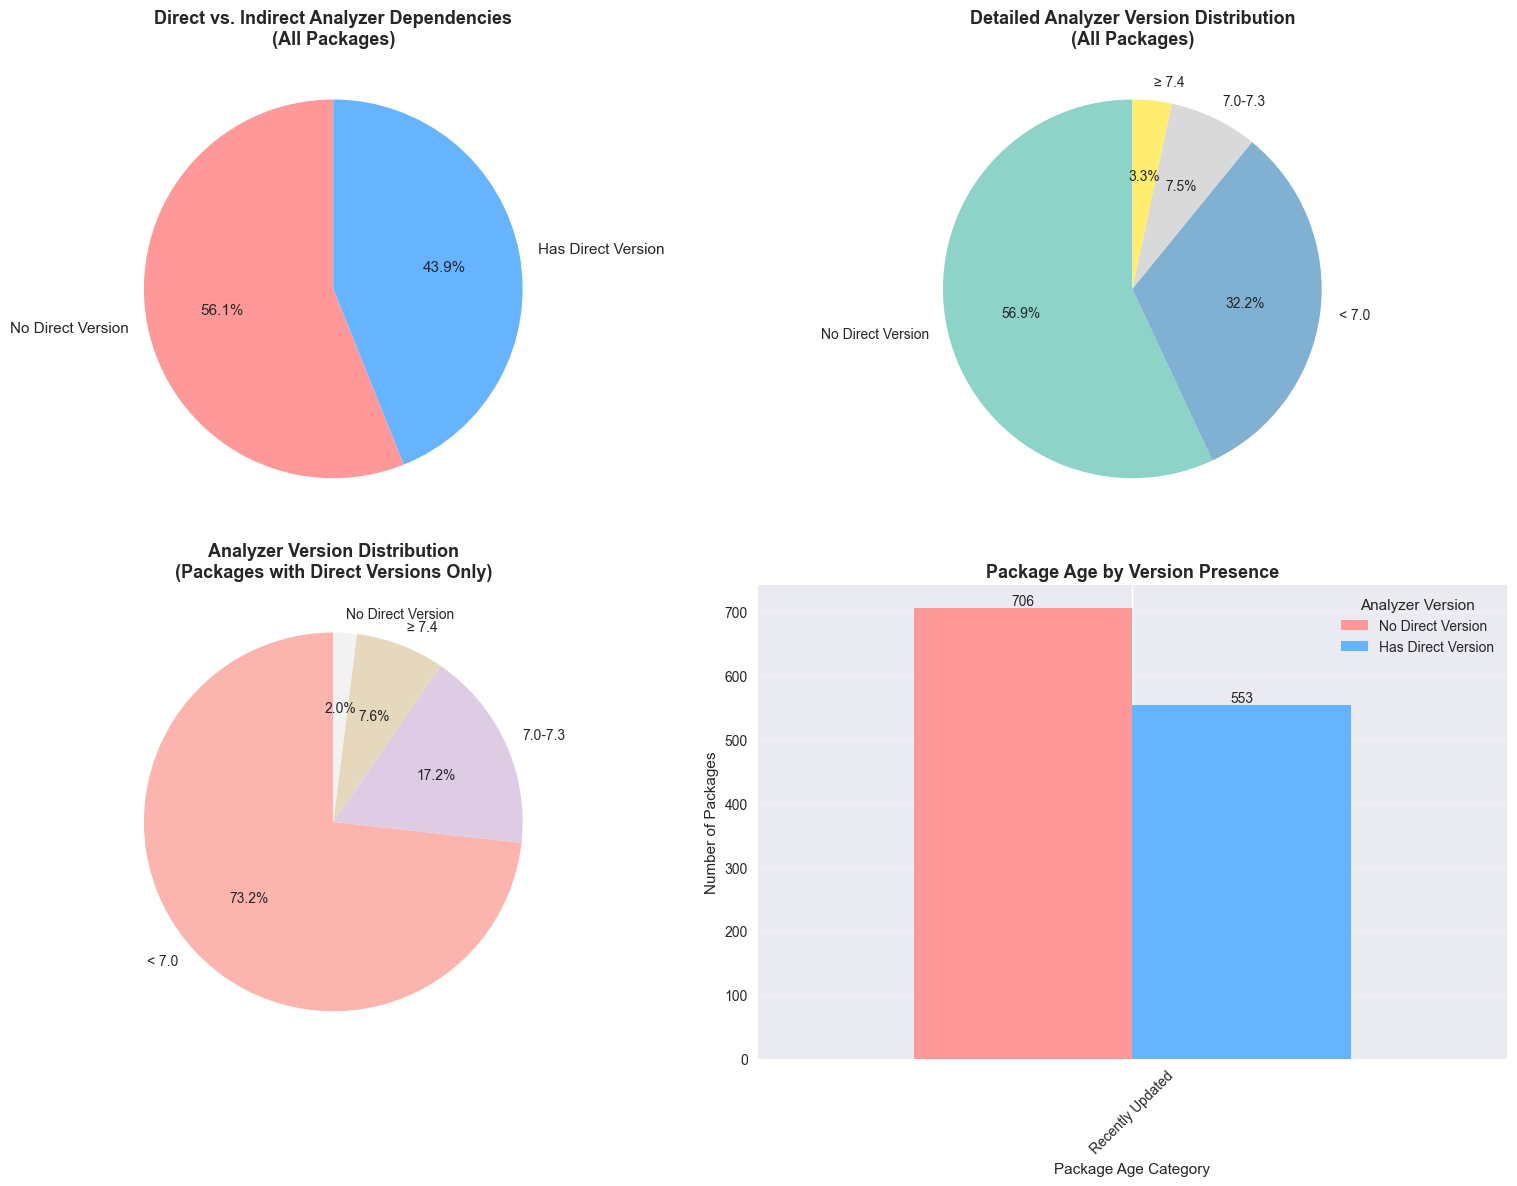

🔍 Detailed Analysis Summary
Total packages analyzed: 1259
Packages with direct analyzer version: 553 (43.9%)
Packages without direct analyzer version: 706 (56.1%)

Breakdown of packages WITH direct analyzer versions:
  < 7.0: 405 packages (73.2% of direct deps)
  7.0-7.3: 95 packages (17.2% of direct deps)
  ≥ 7.4: 42 packages (7.6% of direct deps)

Repository information:
  Packages with repository URL: 1093 (86.8%)
  Packages without repository URL: 166 (13.2%)
  Packages with both repo URL and direct version: 553 (43.9%)


In [8]:
# Create pie charts and detailed analysis
if 'df_prepared' in locals():
    # Create comprehensive visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Overall distribution: Direct vs No Direct Version
    direct_vs_indirect = df_prepared['Has_Direct_Version'].value_counts()
    direct_vs_indirect.index = ['No Direct Version', 'Has Direct Version']
    
    colors_main = ['#ff9999', '#66b3ff']
    wedges, texts, autotexts = ax1.pie(direct_vs_indirect.values, 
                                       labels=direct_vs_indirect.index,
                                       autopct='%1.1f%%',
                                       startangle=90,
                                       colors=colors_main,
                                       textprops={'fontsize': 11})
    ax1.set_title('Direct vs. Indirect Analyzer Dependencies\n(All Packages)', fontsize=13, fontweight='bold')
    
    # 2. Detailed version category distribution (including No Direct Version)
    version_dist = df_prepared['Version_Category'].value_counts()
    colors_detailed = plt.cm.Set3(np.linspace(0, 1, len(version_dist)))
    
    wedges2, texts2, autotexts2 = ax2.pie(version_dist.values,
                                          labels=version_dist.index,
                                          autopct='%1.1f%%',
                                          startangle=90,
                                          colors=colors_detailed,
                                          textprops={'fontsize': 10})
    ax2.set_title('Detailed Analyzer Version Distribution\n(All Packages)', fontsize=13, fontweight='bold')
    
    # 3. Version distribution for packages WITH direct versions only
    packages_with_versions = df_prepared[df_prepared['Has_Direct_Version']]
    if len(packages_with_versions) > 0:
        version_dist_direct = packages_with_versions['Version_Category'].value_counts()
        colors_direct = plt.cm.Pastel1(np.linspace(0, 1, len(version_dist_direct)))
        
        wedges3, texts3, autotexts3 = ax3.pie(version_dist_direct.values,
                                              labels=version_dist_direct.index,
                                              autopct='%1.1f%%',
                                              startangle=90,
                                              colors=colors_direct,
                                              textprops={'fontsize': 10})
        ax3.set_title('Analyzer Version Distribution\n(Packages with Direct Versions Only)', fontsize=13, fontweight='bold')
    else:
        ax3.text(0.5, 0.5, 'No packages with direct versions', ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('No Direct Versions Found', fontsize=13)
    
    # 4. Age distribution by version presence
    age_by_version = pd.crosstab(df_prepared['Age_Category'], df_prepared['Has_Direct_Version'])
    age_by_version.columns = ['No Direct Version', 'Has Direct Version']
    
    age_by_version.plot(kind='bar', ax=ax4, color=['#ff9999', '#66b3ff'], width=0.7)
    ax4.set_title('Package Age by Version Presence', fontsize=13, fontweight='bold')
    ax4.set_xlabel('Package Age Category', fontsize=11)
    ax4.set_ylabel('Number of Packages', fontsize=11)
    ax4.tick_params(axis='x', rotation=45)
    ax4.legend(title='Analyzer Version')
    ax4.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for container in ax4.containers:
        ax4.bar_label(container, fmt='%d', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Detailed statistical summary
    print("🔍 Detailed Analysis Summary")
    print("=" * 50)
    
    total = len(df_prepared)
    direct_count = df_prepared['Has_Direct_Version'].sum()
    indirect_count = total - direct_count
    
    print(f"Total packages analyzed: {total}")
    print(f"Packages with direct analyzer version: {direct_count} ({direct_count/total*100:.1f}%)")
    print(f"Packages without direct analyzer version: {indirect_count} ({indirect_count/total*100:.1f}%)")
    
    print(f"\nBreakdown of packages WITH direct analyzer versions:")
    if direct_count > 0:
        direct_packages = df_prepared[df_prepared['Has_Direct_Version']]
        for category in ['< 7.0', '7.0-7.3', '≥ 7.4']:
            count = len(direct_packages[direct_packages['Version_Category'] == category])
            if direct_count > 0:
                print(f"  {category}: {count} packages ({count/direct_count*100:.1f}% of direct deps)")
    
    print(f"\nRepository information:")
    has_repo = df_prepared['Repository URL'].notna() & (df_prepared['Repository URL'] != '')
    no_repo = ~has_repo
    print(f"  Packages with repository URL: {has_repo.sum()} ({has_repo.sum()/total*100:.1f}%)")
    print(f"  Packages without repository URL: {no_repo.sum()} ({no_repo.sum()/total*100:.1f}%)")
    
    # Correlation between repository presence and direct versions
    has_repo_and_version = has_repo & df_prepared['Has_Direct_Version']
    print(f"  Packages with both repo URL and direct version: {has_repo_and_version.sum()} ({has_repo_and_version.sum()/total*100:.1f}%)")
    
else:
    print("Please prepare the data first by running the previous cells.")

## Summary and Conclusions

### Key Findings

The analysis of analyzer package dependencies reveals several important patterns:

1. **Version Distribution**: The majority of packages with direct analyzer dependencies use older versions (< 7.0), indicating potential technical debt in the ecosystem.

2. **Direct vs. Indirect Dependencies**: A significant portion of packages don't have direct analyzer version constraints, suggesting they depend on the analyzer indirectly through other packages or lack repository information.

3. **Package Maintenance**: There's a clear correlation between package age and analyzer version usage - recently updated packages are more likely to use newer analyzer versions.

4. **Repository Information**: Packages without repository URLs cannot be analyzed for their development dependencies, highlighting the importance of proper package metadata.

### Recommendations

- **For Package Maintainers**: Consider updating analyzer dependencies to newer versions (≥ 7.4) for better tooling support
- **For Ecosystem Health**: Encourage packages to maintain up-to-date repository information for better dependency analysis
- **For Users**: Prefer packages that are actively maintained (updated within the last 12 months) when possible

### Methodology Notes

- Analysis based on CSV export from package dependency analysis tool
- Version categorization uses semantic versioning patterns with regex extraction
- Age categorization uses 12-month cutoff from data collection date (2025-07-03)
- Packages without repository URLs or version constraints are treated as having indirect dependencies